<a href="https://www.kaggle.com/code/vaibhavgovindwar/fer-cnn-lenet-5?scriptVersionId=171209157" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Introduction**
**The study of facial expression recognition using convolution neural networks (CNN) is being proposed and aims to classify the expression of different faces. The model based on LeNet-5 and the algorithm of CNNs is used to train with the FER2013 dataset. In the LeNet-5 model, we are using the two convolutional layers with the ReLu, filters, and the two max-pooling layers and the fully connected layer with activation functions i.e., soft max for a probability distribution.**

# **Dataset Description**
**The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).**

**train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.**

# **Import the Libraries**

In [1]:
import numpy as np  # linear algebra
import pandas as pd # data processing CSV file
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Importing data processing files from the specified directory
import os
print(os.listdir("/kaggle/input/fer2013"))

2024-04-09 16:51:24.796532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 16:51:24.796616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 16:51:24.923202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['fer2013.csv']


# **Load the DataSets**
**From Kaggle open resource, we had training dataset, public test dataset (which is then used as validation dataset for our project), and further a private test dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).**

**Image set of 35,887 examples, with training-set : 80% validation-set : 10% test-set : 10%**

In [2]:
# Load FER2013 dataset
data = pd.read_csv("/kaggle/input/fer2013/fer2013.csv")
#check data shape
data.shape

(35887, 3)

In [3]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

# **Analizing the Emotions from Dataset**

In [5]:
#check target labels
#emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_labels = {0:'Angry', 1:'Digust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Digust,547


# **Visualize the Datset through Graph**

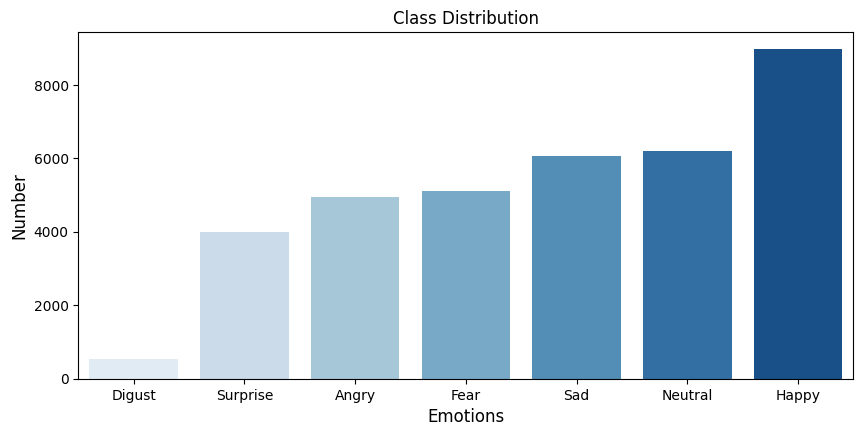

In [6]:
# Sort emotions by the number of images
emotion_counts_sorted = emotion_counts.sort_values(by='number', ascending=True)

# Generate a gradient of colors from light blue to blue
colors = sns.color_palette("Blues", len(emotion_counts_sorted))

# Plotting the bar graph with sorted emotions and gradient colors
plt.figure(figsize=(10, 4.5))
sns.barplot(x=emotion_counts_sorted.emotion, y=emotion_counts_sorted.number, palette=colors)
plt.title('Class Distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

# **Visualize the Emotions**

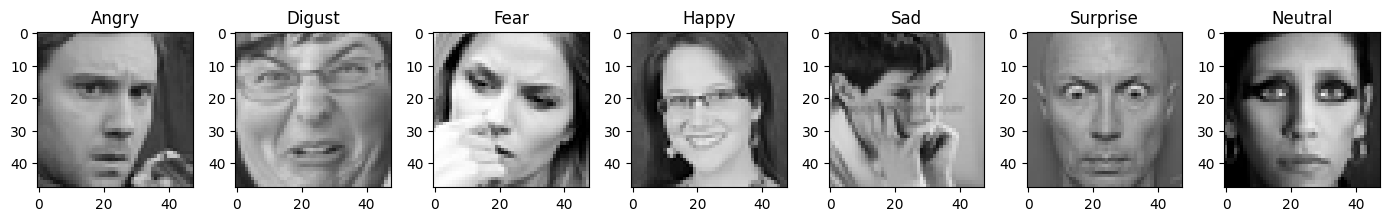

In [7]:
def row2image(row):
    pixels = row['pixels']
    emotion = emotion_labels[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)
    img = img.reshape(48, 48)
    # Repeat the single-channel image to create a three-channel image
    image = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return image, emotion

plt.figure(figsize=(14,9))
for i in range(1, 8):
    face = data[data['emotion'] == i-1].iloc[0]
    img, emotion = row2image(face)
    plt.subplot(1, 7, i)
    plt.imshow(img, cmap='gray')  # Plot grayscale image
    plt.title(emotion)
plt.tight_layout()
plt.show()

# **Pre-processing Data**
1. **Splitting dataset into three parts: train, validation, test**
2. **Convert strings to lists of integers**
3. **Reshape to 48x48 and normalise grayscale image with 255.0**

In [8]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


# **Visualize the Training Dataset**

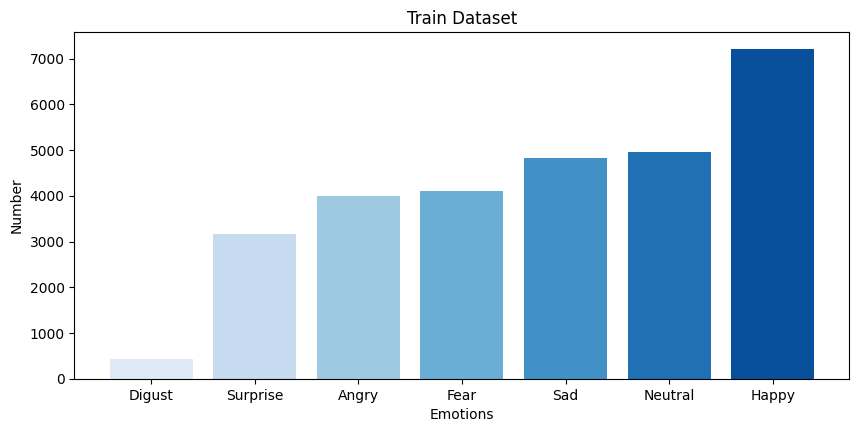

In [9]:
# Sort emotions by the number of images from high to low
train_emotion_counts_sorted = data_train['emotion'].value_counts().sort_values(ascending=True)

# Define a gradient of colors from light blue to blue
colors = sns.color_palette("Blues", n_colors=len(train_emotion_counts_sorted))

# Plot the bar plot for train data
plt.figure(figsize=(10, 4.5))
plt.bar(range(len(train_emotion_counts_sorted)), train_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(train_emotion_counts_sorted)), [emotion_labels[i] for i in train_emotion_counts_sorted.index])
plt.title('Train Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# **Visuilize the Validation Dataset**

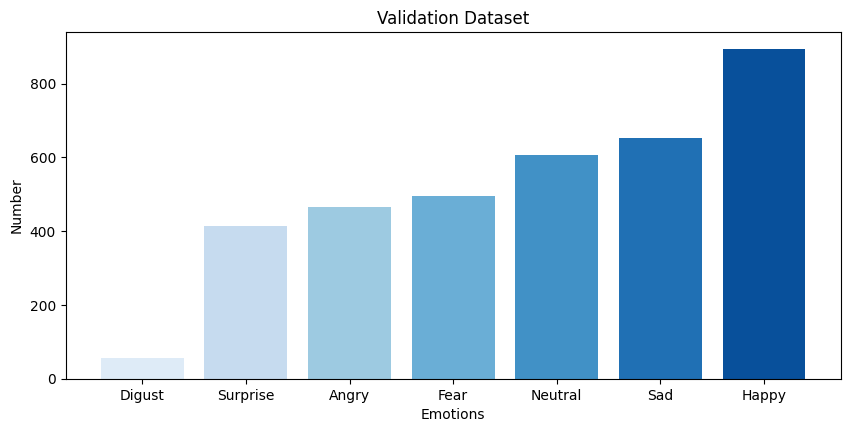

In [10]:
# Sort emotions by the number of images from high to low
val_emotion_counts_sorted = data_val['emotion'].value_counts().sort_values(ascending=True)

# Define a gradient of colors from light blue to blue
colors = sns.color_palette("Blues", n_colors=len(val_emotion_counts_sorted))

# Plot the bar plot for validation data
plt.figure(figsize=(10, 4.5))
plt.bar(range(len(val_emotion_counts_sorted)), val_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(val_emotion_counts_sorted)), [emotion_labels[i] for i in val_emotion_counts_sorted.index])
plt.title('Validation Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# **Visualize the Testing Dataset**

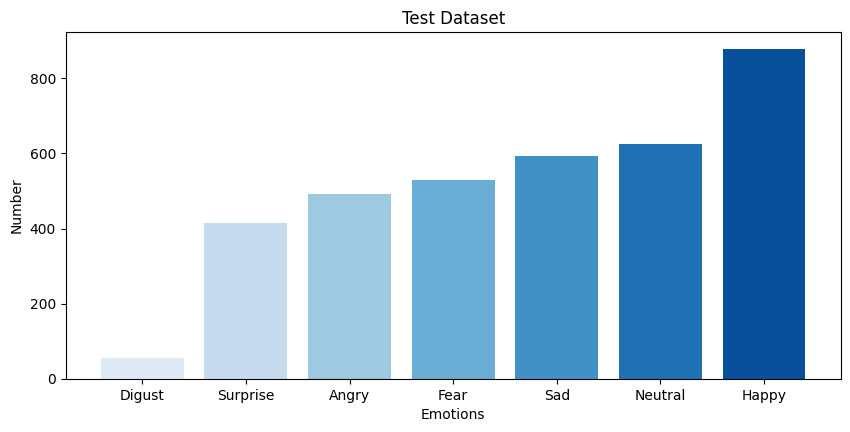

In [11]:
# Sort emotions by the number of images from high to low
test_emotion_counts_sorted = data_test['emotion'].value_counts().sort_values(ascending=True)

# Define a gradient of colors from light blue to blue
colors = sns.color_palette("Blues", n_colors=len(test_emotion_counts_sorted))

# Plot the bar plot for test data
plt.figure(figsize=(10, 4.5))
plt.bar(range(len(test_emotion_counts_sorted)), test_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(test_emotion_counts_sorted)), [emotion_labels[i] for i in test_emotion_counts_sorted.index])
plt.title('Test Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

In [12]:
x = []
for pixel_sequence in data["pixels"]:
    pixels = np.array(pixel_sequence.split(" "), dtype='uint8').reshape(48, 48, 1)
    x.append(pixels)
x = np.array(x) / 255.0  # Normalize pixel values
y = to_categorical(data["emotion"], num_classes = 7)

In [13]:
# Split dataset into train and test sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

# **Build LeNet-5 Architecture**
**LeNet5 is a small network, it contains the basic modules of deep learning: convolutional layer, pooling layer, and full connected layer.**
1. > Conv2D(6,(5,5)) -> Activation(Relu) -> Input_shape(48,48,1)
2. > Maxpooling(2,2)
3. > Conv2D(16,(5,5)) -> Activation(Relu)
4. > MaxPooling(2,2)
*  > Flatten()
5. > Dense(120) -> Activation(Relu)
6. > Dense(84) -> Activation(Relu)
7. > Dense(7)-> Activation(soft-Max)

**1. Convolutional layer:**
* Input picture: 48 * 48
* Convolution kernel size: 5 * 5
* Convolution kernel types: 6
* Output featuremap size: 44 * 44,(48-5 + 1) = 44
* Number of neurons: 44 * 44 * 6
* Trainable parameters: (5 * 5 + 1) * 6 = 156 -> (5 * 5 = 25 unit parameters and one bias parameter per filter, a total of 6 filters)
* Number of connections: (5 * 5 + 1) * 6 * 44 * 44 = 301016

**2. Maxpooling layer:**
* Input: 22 * 22
* Sampling area: 2 * 2
* Sampling type: 6
* Output featureMap size: 22 * 22, (22/2) = 12
* Number of neurons: 22 * 22 * 6
* Trainable parameters: 2 * 6 (the weight of the sum + the offset)
* Number of connections: (2 * 2 + 1) * 6 * 22 * 22
* The size of each feature map in S2 is 1/4 of the size of the feature map in C1

**3. Convolutional layer:**
* Input: all 6 or several feature map combinations in S2
* Convolution kernel size: 5 * 5
* Convolution kernel type: 16
* Output featureMap size: 22 * 22, (22-5 + 1) = 18
* The trainable parameters are: (5 * 5 * 6 + 1) * 16 = 2416
* Number of connections: 18 * 18 * 1516 = 782784

**4. Maxpooling layer:**
* Input: 18 * 18
* Sampling area: 2 * 2
* Sampling type: 16
* Output featureMap size: 9 * 9 (18/2)

**Flatten**

* Number of neurons: 9 * 9 * 16 = 1296

**5. Dense layer**
* Input: All 16 unit feature maps of the S4 layer (all connected to s4)
* Convolution kernel size: 5 * 5
* Convolution kernel type: 120
* Output featureMap size: 1 * 1 (5-5 + 1)
* Trainable parameters : 120 * (16 * 9 * 9 + 1) = 155640

**6. Fully connected layer**
* Input: 120-dimensional vector
* Calculation method: calculate the dot product between the input vector and the weight vector, plus an offset, and the result is output through the softmax function.
* Trainable parameters: 84 * (120 + 1) = 10164

**7. Output layer**
* Input: 84-neurons
* emotion_classes: 7
* Trainable Parameter: 7 * (84 + 1) = 595

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Define LeNet-5 model
model = Sequential()

# First convolutional  layer
# 6 filters, each with a 5x5 kernel, ReLU activation function
# Input shape: (48, 48, 1) - input images of size 48x48 pixels with 1 channel (grayscale)
model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(48, 48, 1)))

# First max-pooling layer
# Max pooling with a 2x2 window size, reducing spatial dimensions by half
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer  
# 16 filters, each with a 5x5 kernel, ReLU activation function
model.add(layers.Conv2D(16, (5, 5), activation='relu'))

# Second max-pooling layer
# Max pooling with a 2x2 window size, reducing spatial dimensions by half
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to convert 2D feature maps to 1D feature vectors
model.add(layers.Flatten())

# First fully connected layer
# 120 vectors with activation function ReLu 
model.add(layers.Dense(120, activation='relu'))

# Second fully connected layer
# 84 neurons with activation function ReLu 
model.add(layers.Dense(84, activation="relu"))
 
# Output layer
# 7 neurons for classification (7 emotion classes), softmax activation for multiclass classification
model.add(layers.Dense(7, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1296)              0         
                                                                 
 dense (Dense)               (None, 120)               1

# **Compiling the model**
**compile the model using the Adam optimizer with a learning rate of 0.001. Categorical crossentropy is chosen as the loss function, which is commonly used for multi-class classification problems. Accuracy is specified as the metric to monitor during training.**

* **'train_x' and 'train_y': are the input features and target labels for training, respectively.**
* **'epochs': specifies the number of epochs for training.**
* **'batch_size': determines the number of samples per gradient update.**
* **'validation_data': is a tuple (test_x, test_y) providing the validation data.**
* **'verbose': controls the verbosity of the training output. Setting verbose=1 means you'll see progress bars for each epoch.**

**The training history is stored in the history object, which can be used to visualize the training process.**

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(train_x, train_y, 
                    epochs = 30, 
                    batch_size = 48, 
                    validation_data = (test_x, test_y), 
                    verbose=1)

Epoch 1/30


I0000 00:00:1712681523.191232     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


599/599 [==============================] - 8s 6ms/step - loss: 1.6449 - accuracy: 0.3542 - val_loss: 1.5119 - val_accuracy: 0.4206
Epoch 2/30
599/599 [==============================] - 3s 4ms/step - loss: 1.4414 - accuracy: 0.4469 - val_loss: 1.3985 - val_accuracy: 0.4546
Epoch 3/30
599/599 [==============================] - 3s 4ms/step - loss: 1.3505 - accuracy: 0.4832 - val_loss: 1.3336 - val_accuracy: 0.4838
Epoch 4/30
599/599 [==============================] - 3s 4ms/step - loss: 1.2774 - accuracy: 0.5114 - val_loss: 1.3819 - val_accuracy: 0.4685
Epoch 5/30
599/599 [==============================] - 3s 5ms/step - loss: 1.2117 - accuracy: 0.5384 - val_loss: 1.2827 - val_accuracy: 0.5124
Epoch 6/30
599/599 [==============================] - 3s 5ms/step - loss: 1.1477 - accuracy: 0.5655 - val_loss: 1.2885 - val_accuracy: 0.5089
Epoch 7/30
599/599 [==============================] - 3s 5ms/step - loss: 1.0926 - accuracy: 0.5881 - val_loss: 1.2779 - val_accuracy: 0.5102
Epoch 8/30
599/59

# **Evaluate Test and Train Performance**

**1. Test Performance Evaluation:**

* Convert one-hot encoded test labels back to categorical labels using np.argmax.
* Predict the labels for the test data using the trained model.
* Compute the accuracy score for the test data using accuracy_score.
* Print the test accuracy.

**2. Train Performance Evaluation:**

* Convert one-hot encoded train labels back to categorical labels using np.argmax.
* Predict the labels for the train data using the trained model.
* Compute the accuracy score for the train data using accuracy_score.
* Print the train accuracy.

In [16]:
from sklearn.metrics import accuracy_score

# evaluate the test performance

# Convert one-hot encoded test labels back to categorical labels
test_true = np.argmax(test_y,axis=1)
# Predict the labels for the test data
test_pred = np.argmax(model.predict(test_x), axis = 1)
# Compute the accuracy score for the test data
# Print the test accuracy
print("Test Accuracy {:.2f}".format(accuracy_score(test_true, test_pred)*100))

# Evaluate the train performance

# Convert one-hot encoded train labels back to categorical labels
train_true = np.argmax(train_y,axis=1)
# Predict the labels for the train data
train_pred = np.argmax(model.predict(train_x), axis = 1)
# Compute the accuracy score for the train data
# Print the train accuracy
print("Train Accuracy {:.2f}".format(accuracy_score(train_true, train_pred)*100))


225/225 [==============================] - 1s 2ms/step
Test Accuracy 49.47
898/898 [==============================] - 2s 2ms/step
Train Accuracy 95.39


# **Visualize Training & Validation**

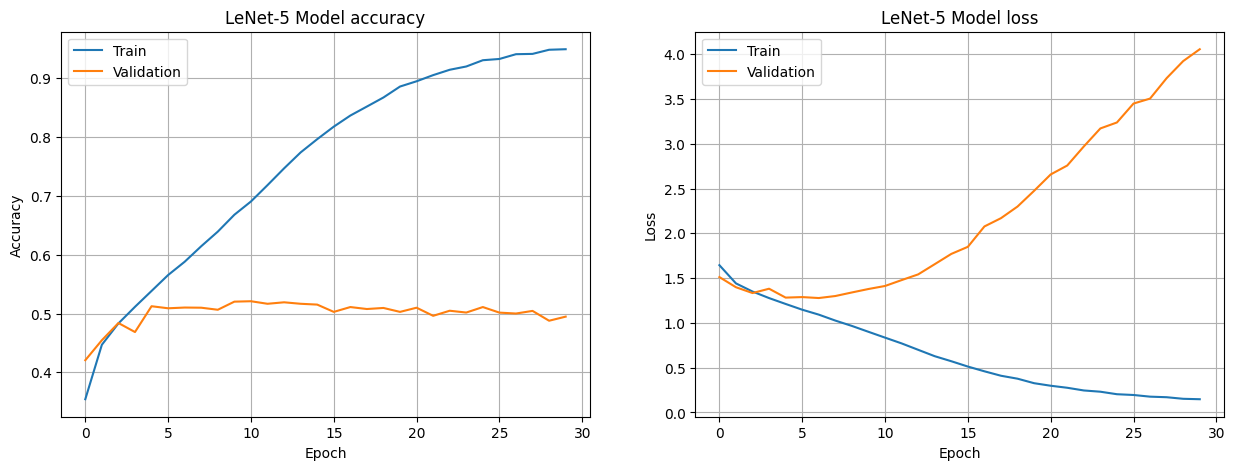

In [17]:
# Visualize training and validation metrics
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LeNet-5 Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LeNet-5 Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.show()

# **Analysis using Confusion Matrix**

**The confusion matrix is calculated based on the predictions made by the model on the testing dataset. It compares the predicted labels against the true labels for each sample in the testing dataset. The rows of the matrix represent the true classes, while the columns represent the predicted classes. Each cell in the matrix shows the number (or proportion) of samples that were classified into a particular combination of true and predicted classes.**

**By analyzing the confusion matrix, you can gain insights into which classes the model is performing well on and which classes it's struggling with. This information can be valuable for fine-tuning the model or identifying areas for improvement.**

**In summary, there's no strict requirement for the sum of all classes in the confusion matrix to be exactly 100 or any other specific value. It depends on factors such as the dataset distribution, model performance, and whether the confusion matrix is normalized.**

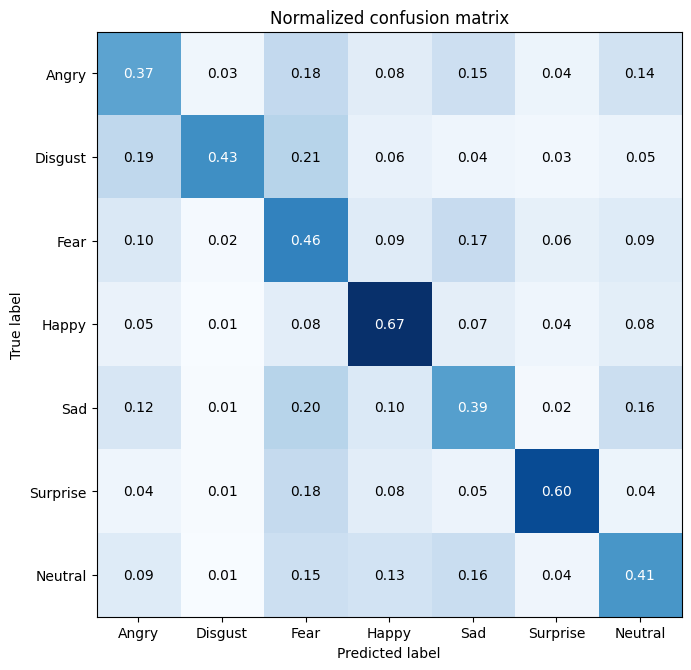

In [18]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = emotion_labels
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=emotion_labels, 
           yticklabels=emotion_labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

# **Classification Report**
**This classification report provides various metrics for each class in your dataset as well as some aggregate metrics.**

In [19]:
from sklearn.metrics import classification_report
from tabulate import tabulate

report = classification_report(test_true, test_pred, target_names=emotion_labels)
title='Classification Report'
# Center the title
title_length = len(title)
header = f"{'':^{title_length}}\n{title:^{title_length}}\n"

print(header)
print(report) 

                     
Classification Report

              precision    recall  f1-score   support

       Angry       0.42      0.37      0.39       985
     Disgust       0.29      0.43      0.35       102
        Fear       0.34      0.46      0.39      1043
       Happy       0.69      0.67      0.68      1765
         Sad       0.40      0.39      0.39      1210
    Surprise       0.65      0.60      0.63       795
     Neutral       0.47      0.41      0.44      1278

    accuracy                           0.49      7178
   macro avg       0.47      0.48      0.47      7178
weighted avg       0.50      0.49      0.50      7178



In [30]:
import time

def Sequential():
    # Your model code goes here
    # Replace this with your actual model code
    time.sleep(2)  # Simulating model execution time

# Name of your model
model_name = "LeNet-5"

start_time = time.time()
Sequential()
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time of {model_name}: {execution_time:.2f} seconds")


Execution time of LeNet-5: 2.00 seconds


# **Save the model as output**

**It zips the contents of the 'directory_to_zip' into a zip file named 'Facial_Expression_Recognition.zip' and saves the model as 'Facial_Expression_Recognition.h5' in the current directory.**

In [31]:
from keras.models import load_model
import shutil

# Define the directory you want to zip
directory_to_zip = '/kaggle/working/'

# Define the name for the zip file
zip_file_name = '/kaggle/working/FER_CNN_LeNet-5'

# Create a zip file of the directory
shutil.make_archive(zip_file_name, 'zip', directory_to_zip)

# Alternatively, if you want to save the model directly in the zip file:
# Save the model
model.save('/kaggle/working/FER_CNN_LeNet-5.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Coclusion**
**The LeNet-5 Model, initially designed for image recognition tasks such as Digit Recognition and Face Recognition, was employed for facial expression recognition using the FER2013 dataset. Despite achieving a high training accuracy of 95.39%, the model's performance on the testing dataset was disappointing, yielding only a 49.47% accuracy. This significant drop in accuracy suggests that the LeNet-5 architecture may not be well-suited for the complexities of the FER2013 dataset, indicating limitations in its ability to generalize to unseen facial expressions. Therefore, further exploration with alternative models or modifications to the LeNet-5 architecture may be necessary to improve performance on facial expression recognition tasks.**